<a href="https://colab.research.google.com/github/muhiqbalalamin/DeepLearning/blob/main/RNN_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pytorch**

In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
import os

In [138]:
# Reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# hyperparameters
vocab_size = 15000
maxlen = 200
embedding_dim = 100
hidden_size = 128
num_layers = 1
batch_size = 32
epochs = 15
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and prepare IMDB dataset
def load_dataset(vocab_size=15000, maxlen=200, batch_size=32):
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
    x_train = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
    x_test = pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')

    train_lengths = np.array([min(len(seq), maxlen) for seq in x_train])
    test_lengths = np.array([min(len(seq), maxlen) for seq in x_test])

    train_dataset = TensorDataset(
        torch.LongTensor(x_train),
        torch.FloatTensor(y_train),
        torch.LongTensor(train_lengths)
    )
    test_dataset = TensorDataset(
        torch.LongTensor(x_test),
        torch.FloatTensor(y_test),
        torch.LongTensor(test_lengths)
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

train_loader, val_loader = load_dataset(vocab_size, maxlen, batch_size)

Using device: cuda


In [139]:
# RNN Model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        nn.init.xavier_uniform_(self.embedding.weight)
        self.rnn = nn.RNN(
            embedding_dim,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size * 2, 1)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.rnn(packed_embedded)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        final_hidden = out[range(len(out)), lengths - 1, :]
        final_hidden = self.dropout(final_hidden)
        return self.sigmoid(self.fc(final_hidden)).squeeze()

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        nn.init.xavier_uniform_(self.embedding.weight)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size * 2, 1)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (hidden, _) = self.lstm(packed)
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)
        hidden_cat = self.dropout(hidden_cat)
        return self.sigmoid(self.fc(hidden_cat)).squeeze()

# GRU Model
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        nn.init.xavier_uniform_(self.embedding.weight)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size * 2, 1)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, hidden = self.gru(packed)
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)
        hidden_cat = self.dropout(hidden_cat)
        return self.sigmoid(self.fc(hidden_cat)).squeeze()

In [140]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, patience=5):
    model.to(device)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=3, verbose=True)
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    best_val_acc = 0
    not_improved = 0
    os.makedirs('saved_models', exist_ok=True)

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels, lengths in train_loader:
            inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
            preds = torch.round(outputs)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        history['loss'].append(total_loss / len(train_loader))
        history['accuracy'].append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        val_labels, val_preds, val_probs = [], [], []
        with torch.no_grad():
            for inputs, labels, lengths in val_loader:
                inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)
                outputs = model(inputs, lengths)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                probs = outputs
                preds = torch.round(probs)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(preds.cpu().numpy())
                val_probs.extend(probs.cpu().numpy())

        val_acc = 100 * val_correct / val_total
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_accuracy'].append(val_acc)
        precision = precision_score(val_labels, val_preds, zero_division=0)
        recall = recall_score(val_labels, val_preds, zero_division=0)
        f1 = f1_score(val_labels, val_preds, zero_division=0)
        auc = roc_auc_score(val_labels, val_probs)
        print(f"Epoch {epoch+1}/{epochs}: Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

        scheduler.step(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'saved_models/best_{model.__class__.__name__}.pth')
            print(f"Model improved, saving checkpoint (Val Acc: {val_acc:.2f}%)")
            not_improved = 0
        else:
            not_improved += 1
            if not_improved >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best validation accuracy: {best_val_acc:.2f}%")
                break

    model.load_state_dict(torch.load(f'saved_models/best_{model.__class__.__name__}.pth'))
    return model, history

In [141]:
# Plotting function
def plot_metrics(history, model_name):
    epochs = range(1, len(history['loss']) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], 'b-', marker='o', label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], 'r-', marker='o', label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], 'b-', marker='o', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', marker='o', label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{model_name}_metrics.png')
    plt.show()


Training RNN...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15: Train Acc: 50.06% | Val Acc: 50.45% | Precision: 0.5082 | Recall: 0.2786 | F1: 0.3599 | AUC: 0.5156
Model improved, saving checkpoint (Val Acc: 50.45%)
Epoch 2/15: Train Acc: 54.20% | Val Acc: 50.38% | Precision: 0.5086 | Recall: 0.2277 | F1: 0.3145 | AUC: 0.5133
Epoch 3/15: Train Acc: 57.36% | Val Acc: 51.70% | Precision: 0.5474 | Recall: 0.1964 | F1: 0.2891 | AUC: 0.5422
Model improved, saving checkpoint (Val Acc: 51.70%)
Epoch 4/15: Train Acc: 60.80% | Val Acc: 53.14% | Precision: 0.5857 | Recall: 0.2142 | F1: 0.3137 | AUC: 0.5566
Model improved, saving checkpoint (Val Acc: 53.14%)
Epoch 5/15: Train Acc: 69.46% | Val Acc: 64.57% | Precision: 0.6455 | Recall: 0.6462 | F1: 0.6459 | AUC: 0.6591
Model improved, saving checkpoint (Val Acc: 64.57%)
Epoch 6/15: Train Acc: 75.60% | Val Acc: 65.21% | Precision: 0.6354 | Recall: 0.7138 | F1: 0.6723 | AUC: 0.6726
Model improved, saving checkpoint (Val Acc: 65.21%)
Epoch 7/15: Train Acc: 78.33% | Val Acc: 65.96% | Precision: 0.6768 

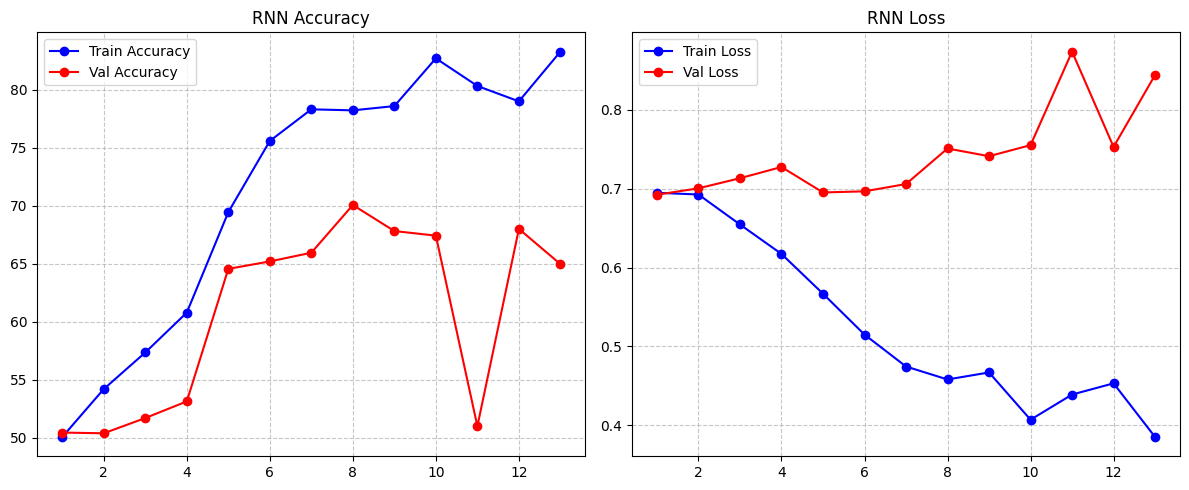

In [142]:
criterion = nn.BCELoss()

# Train RNN Model
print("\nTraining RNN...")
rnn_model = RNNModel(vocab_size, embedding_dim, hidden_size, num_layers)
rnn_optimizer = optim.AdamW(rnn_model.parameters(), lr=learning_rate, weight_decay=1e-4)
rnn_model, rnn_history = train_model(rnn_model, train_loader, val_loader, criterion, rnn_optimizer, device, epochs)
plot_metrics(rnn_history, "RNN")



Training LSTM...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15: Train Acc: 73.58% | Val Acc: 74.50% | Precision: 0.8950 | Recall: 0.5551 | F1: 0.6852 | AUC: 0.8438
Model improved, saving checkpoint (Val Acc: 74.50%)
Epoch 2/15: Train Acc: 87.30% | Val Acc: 80.76% | Precision: 0.7483 | Recall: 0.9268 | F1: 0.8281 | AUC: 0.8985
Model improved, saving checkpoint (Val Acc: 80.76%)
Epoch 3/15: Train Acc: 91.00% | Val Acc: 82.86% | Precision: 0.8549 | Recall: 0.7916 | F1: 0.8220 | AUC: 0.9023
Model improved, saving checkpoint (Val Acc: 82.86%)
Epoch 4/15: Train Acc: 93.32% | Val Acc: 83.28% | Precision: 0.8380 | Recall: 0.8250 | F1: 0.8314 | AUC: 0.9035
Model improved, saving checkpoint (Val Acc: 83.28%)
Epoch 5/15: Train Acc: 95.28% | Val Acc: 81.90% | Precision: 0.8418 | Recall: 0.7856 | F1: 0.8127 | AUC: 0.8906
Epoch 6/15: Train Acc: 96.84% | Val Acc: 82.08% | Precision: 0.8053 | Recall: 0.8460 | F1: 0.8252 | AUC: 0.8806
Epoch 7/15: Train Acc: 97.79% | Val Acc: 81.11% | Precision: 0.7848 | Recall: 0.8573 | F1: 0.8195 | AUC: 0.8749
Epoch 8/

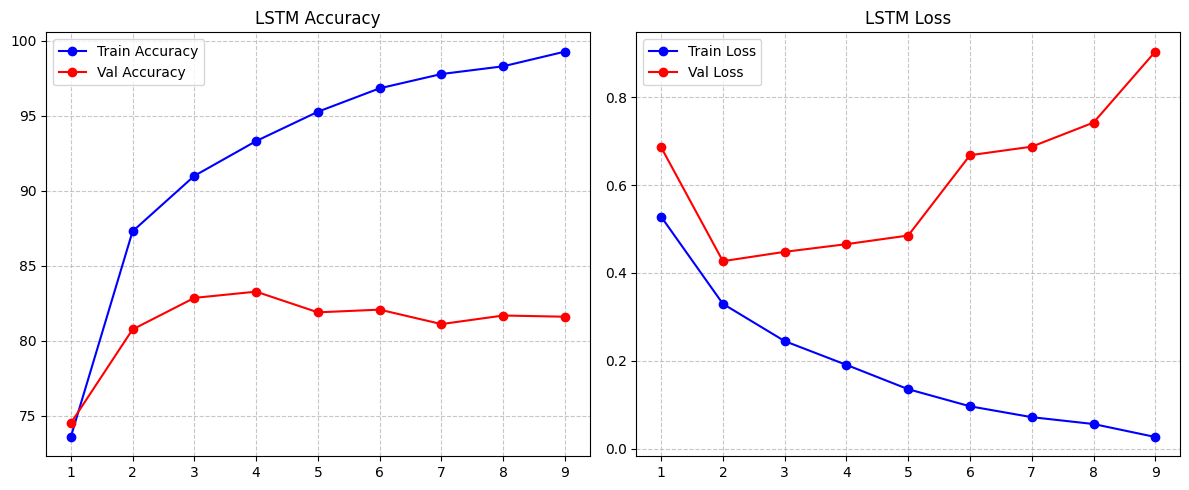

In [143]:
# Train LSTM Model
print("\nTraining LSTM...")
lstm_model = LSTMModel(vocab_size, embedding_dim, hidden_size, num_layers)
lstm_optimizer = optim.AdamW(lstm_model.parameters(), lr=learning_rate, weight_decay=1e-4)
lstm_model, lstm_history = train_model(lstm_model, train_loader, val_loader, criterion, lstm_optimizer, device, epochs)
plot_metrics(lstm_history, "LSTM")


Training GRU...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15: Train Acc: 76.26% | Val Acc: 83.82% | Precision: 0.7919 | Recall: 0.9174 | F1: 0.8501 | AUC: 0.9261
Model improved, saving checkpoint (Val Acc: 83.82%)
Epoch 2/15: Train Acc: 90.62% | Val Acc: 86.08% | Precision: 0.8672 | Recall: 0.8522 | F1: 0.8596 | AUC: 0.9365
Model improved, saving checkpoint (Val Acc: 86.08%)
Epoch 3/15: Train Acc: 95.33% | Val Acc: 84.76% | Precision: 0.8565 | Recall: 0.8350 | F1: 0.8456 | AUC: 0.9244
Epoch 4/15: Train Acc: 97.62% | Val Acc: 84.44% | Precision: 0.8292 | Recall: 0.8674 | F1: 0.8479 | AUC: 0.9206
Epoch 5/15: Train Acc: 98.83% | Val Acc: 83.33% | Precision: 0.8537 | Recall: 0.8046 | F1: 0.8284 | AUC: 0.9102
Epoch 6/15: Train Acc: 99.25% | Val Acc: 83.77% | Precision: 0.8608 | Recall: 0.8058 | F1: 0.8324 | AUC: 0.9102
Epoch 7/15: Train Acc: 99.74% | Val Acc: 83.83% | Precision: 0.8290 | Recall: 0.8523 | F1: 0.8405 | AUC: 0.9101
Early stopping at epoch 7. Best validation accuracy: 86.08%


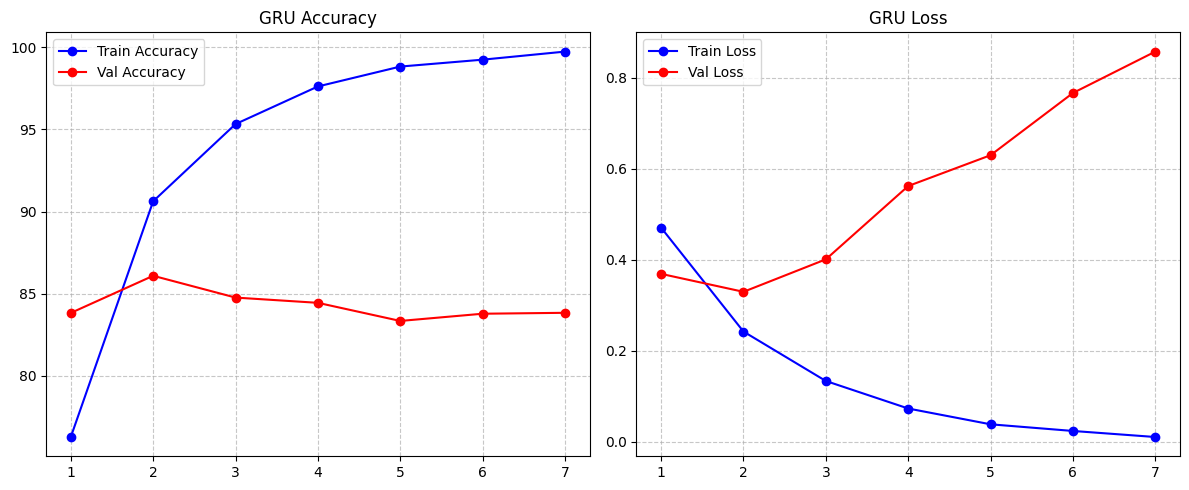

In [144]:
# Train GRU Model
print("\nTraining GRU...")
gru_model = GRUModel(vocab_size, embedding_dim, hidden_size, num_layers)
gru_optimizer = optim.AdamW(gru_model.parameters(), lr=learning_rate, weight_decay=1e-4)
gru_model, gru_history = train_model(gru_model, train_loader, val_loader, criterion, gru_optimizer, device, epochs)
plot_metrics(gru_history, "GRU")


Model Comparison:
RNN Accuracy: 70.08%
LSTM Accuracy: 83.28%
GRU Accuracy: 86.08%


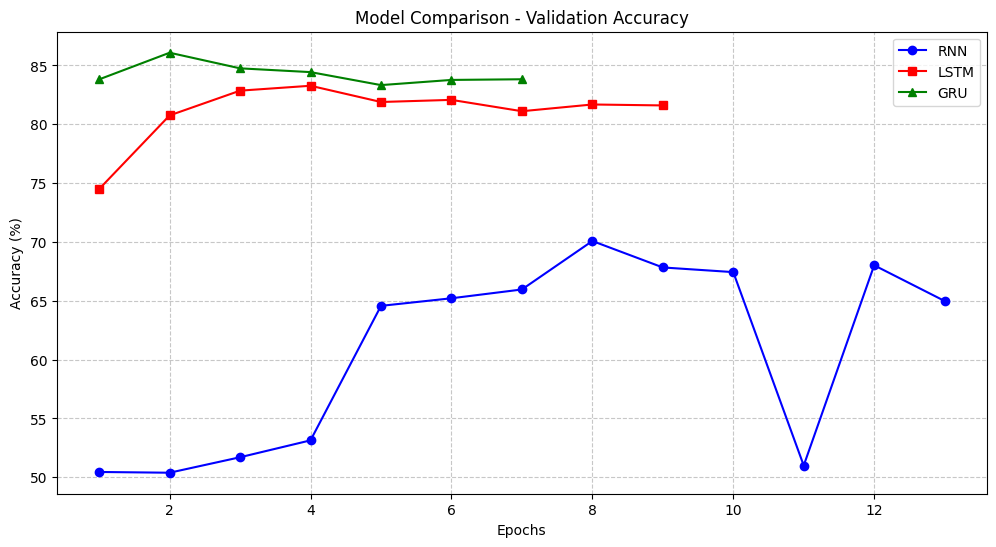

In [145]:
# Compare all models
print("\nModel Comparison:")
print(f"RNN Accuracy: {max(rnn_history['val_accuracy']):.2f}%")
print(f"LSTM Accuracy: {max(lstm_history['val_accuracy']):.2f}%")
print(f"GRU Accuracy: {max(gru_history['val_accuracy']):.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(rnn_history['val_accuracy'])+1), rnn_history['val_accuracy'], 'b-', marker='o', label='RNN')
plt.plot(range(1, len(lstm_history['val_accuracy'])+1), lstm_history['val_accuracy'], 'r-', marker='s', label='LSTM')
plt.plot(range(1, len(gru_history['val_accuracy'])+1), gru_history['val_accuracy'], 'g-', marker='^', label='GRU')
plt.title('Model Comparison - Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.savefig('model_comparison.png')
plt.show()

# **TensorFlow**

In [146]:
!pip install tensorflow

In [147]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

In [148]:
# Set seed for reproducibility
def set_seed(seed=42):
    tf.random.set_seed(seed)

set_seed()

# Load IMDb dataset and preprocess
def load_imdb_dataset(vocab_size=10000, maxlen=200, batch_size=64):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)

    # Padding sequences to fixed length
    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

    # Create TensorFlow Datasets
    train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_data, test_data, vocab_size

train_data, test_data, vocab_size = load_imdb_dataset()

In [149]:
# Define RNN-based models
class RNNModel(tf.keras.Model):
    def __init__(self, hidden_size):
        super(RNNModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64)
        self.rnn = tf.keras.layers.SimpleRNN(hidden_size)
        self.fc = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.embedding(x)
        x = self.rnn(x)
        return self.fc(x)

class LSTMModel(tf.keras.Model):
    def __init__(self, hidden_size):
        super(LSTMModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64)
        self.lstm = tf.keras.layers.LSTM(hidden_size)
        self.fc = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.embedding(x)
        x = self.lstm(x)
        return self.fc(x)

class GRUModel(tf.keras.Model):
    def __init__(self, hidden_size):
        super(GRUModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64)
        self.gru = tf.keras.layers.GRU(hidden_size)
        self.fc = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.embedding(x)
        x = self.gru(x)
        return self.fc(x)

In [153]:
# Training and Evaluation functions
def train_tf_model(model, dataset, epochs=5):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(dataset, epochs=epochs, verbose=2)
    return history

def evaluate_model(model, dataset):
    y_true, y_pred, y_prob = [], [], []

    for x_batch, y_batch in dataset:
        preds = model.predict(x_batch, verbose=0)
        y_true.extend(y_batch.numpy())
        y_prob.extend(preds)
        y_pred.extend(np.round(preds).astype(int).flatten())

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC-ROC: {auc:.4f}")
    return precision, recall, f1, auc


In [154]:
# Train and Evaluate
hidden_size = 128
epochs = 10

print("Training RNN Model...")
rnn_model = RNNModel(hidden_size)
rnn_history = train_tf_model(rnn_model, train_data, epochs)
print("Evaluating RNN Model...")
evaluate_model(rnn_model, test_data)


Training RNN Model...
Epoch 1/10
391/391 - 9s - 24ms/step - accuracy: 0.5617 - loss: 0.6733
Epoch 2/10
391/391 - 6s - 15ms/step - accuracy: 0.7388 - loss: 0.5194
Epoch 3/10
391/391 - 10s - 27ms/step - accuracy: 0.8044 - loss: 0.4301
Epoch 4/10
391/391 - 6s - 15ms/step - accuracy: 0.8537 - loss: 0.3508
Epoch 5/10
391/391 - 6s - 15ms/step - accuracy: 0.8831 - loss: 0.2934
Epoch 6/10
391/391 - 10s - 27ms/step - accuracy: 0.9130 - loss: 0.2280
Epoch 7/10
391/391 - 10s - 26ms/step - accuracy: 0.9175 - loss: 0.2184
Epoch 8/10
391/391 - 6s - 15ms/step - accuracy: 0.9233 - loss: 0.2017
Epoch 9/10
391/391 - 6s - 15ms/step - accuracy: 0.8516 - loss: 0.3389
Epoch 10/10
391/391 - 10s - 27ms/step - accuracy: 0.8706 - loss: 0.2986
Evaluating RNN Model...
Precision: 0.6917, Recall: 0.6045, F1-Score: 0.6452, AUC-ROC: 0.7303


(0.6916880263639692,
 0.60448,
 0.6451502732240437,
 np.float64(0.7303276895999999))

In [155]:
print("Training LSTM Model...")
lstm_model = LSTMModel(hidden_size)
lstm_history = train_tf_model(lstm_model, train_data, epochs)
print("Evaluating LSTM Model...")
evaluate_model(lstm_model, test_data)

Training LSTM Model...
Epoch 1/10
391/391 - 6s - 14ms/step - accuracy: 0.7612 - loss: 0.4693
Epoch 2/10
391/391 - 5s - 14ms/step - accuracy: 0.8867 - loss: 0.2857
Epoch 3/10
391/391 - 4s - 11ms/step - accuracy: 0.9205 - loss: 0.2083
Epoch 4/10
391/391 - 4s - 11ms/step - accuracy: 0.9427 - loss: 0.1569
Epoch 5/10
391/391 - 5s - 14ms/step - accuracy: 0.9560 - loss: 0.1257
Epoch 6/10
391/391 - 5s - 12ms/step - accuracy: 0.9628 - loss: 0.1064
Epoch 7/10
391/391 - 4s - 11ms/step - accuracy: 0.9792 - loss: 0.0631
Epoch 8/10
391/391 - 4s - 11ms/step - accuracy: 0.9816 - loss: 0.0563
Epoch 9/10
391/391 - 4s - 10ms/step - accuracy: 0.9872 - loss: 0.0411
Epoch 10/10
391/391 - 4s - 11ms/step - accuracy: 0.9914 - loss: 0.0274
Evaluating LSTM Model...
Precision: 0.8923, Recall: 0.7772, F1-Score: 0.8308, AUC-ROC: 0.9102


(0.8923486727289428, 0.7772, 0.8308034378073289, np.float64(0.9101578944))

In [156]:
print("Training GRU Model...")
gru_model = GRUModel(hidden_size)
gru_history = train_tf_model(gru_model, train_data, epochs)
print("Evaluating GRU Model...")
evaluate_model(gru_model, test_data)

Training GRU Model...
Epoch 1/10
391/391 - 5s - 13ms/step - accuracy: 0.7862 - loss: 0.4360
Epoch 2/10
391/391 - 5s - 14ms/step - accuracy: 0.8959 - loss: 0.2612
Epoch 3/10
391/391 - 5s - 12ms/step - accuracy: 0.9320 - loss: 0.1825
Epoch 4/10
391/391 - 4s - 10ms/step - accuracy: 0.9579 - loss: 0.1227
Epoch 5/10
391/391 - 4s - 11ms/step - accuracy: 0.9709 - loss: 0.0824
Epoch 6/10
391/391 - 5s - 12ms/step - accuracy: 0.9816 - loss: 0.0557
Epoch 7/10
391/391 - 5s - 14ms/step - accuracy: 0.9883 - loss: 0.0363
Epoch 8/10
391/391 - 4s - 11ms/step - accuracy: 0.9910 - loss: 0.0284
Epoch 9/10
391/391 - 5s - 12ms/step - accuracy: 0.9943 - loss: 0.0192
Epoch 10/10
391/391 - 6s - 14ms/step - accuracy: 0.9958 - loss: 0.0142
Evaluating GRU Model...
Precision: 0.8752, Recall: 0.8413, F1-Score: 0.8579, AUC-ROC: 0.9320


(0.8751664447403462,
 0.84128,
 0.8578887257301354,
 np.float64(0.9319521087999999))

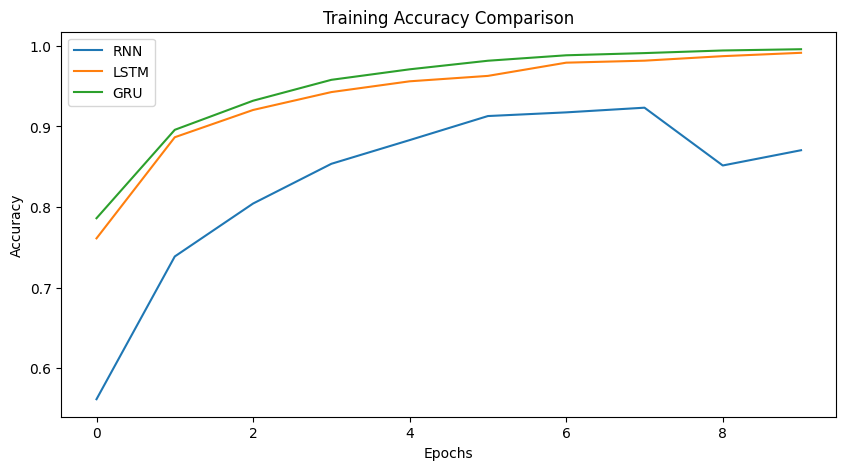

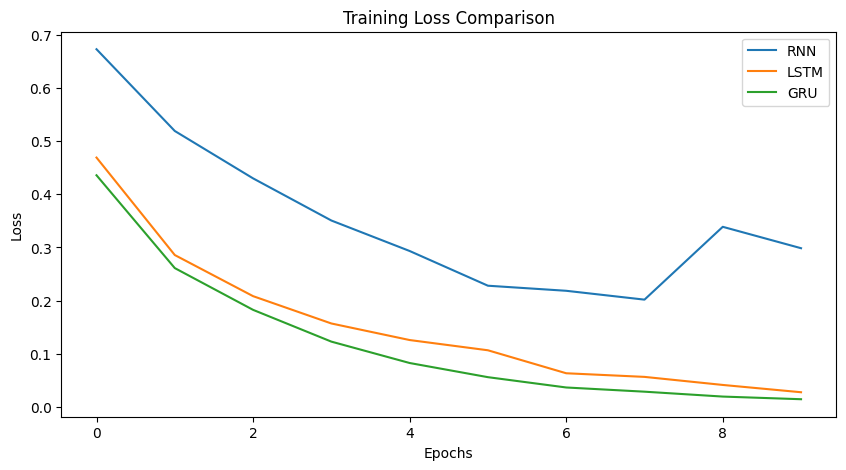

In [157]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(rnn_history.history['accuracy'], label='RNN')
plt.plot(lstm_history.history['accuracy'], label='LSTM')
plt.plot(gru_history.history['accuracy'], label='GRU')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(rnn_history.history['loss'], label='RNN')
plt.plot(lstm_history.history['loss'], label='LSTM')
plt.plot(gru_history.history['loss'], label='GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()